In [1]:
# from IPython.utils import io
# with io.capture_output() as captured:
#   !pip3 install scikit-learn;

import numpy as np

from util import train_test_df, evaluate, interaction_matrix, heatmaps, train_test_mtx
from mfactorization import mf, mf_default_config


def pca(M):
  '''
  reduces dimension of nxm matrix M to nx64
  '''

  from sklearn.decomposition import PCA

  R = PCA(64).fit_transform(M)

  return R

implict loading of dataframes
Max items of a user in test dataset: 36


In [3]:
# 1.
R, Rt = train_test_mtx(return_dfs=False, return_id_maps=False)

# 2.
print("factorizing interaction matrix:")

Q, P = mf(R, print_step=8, lr =(2e-2, 1e-3), n_epochs=400, sampled_epochs=350, sample_size=0.1)
# Q, P = mf(R, **mf_default_config, print_step=5)
Rm = Q @ P.T


factorizing interaction matrix:


59it [00:01, 45.35it/s]

err: 1.36e+04, lr: 0.0131641 

102it [00:02, 50.27it/s]

err: 1.14e+04, lr: 0.0084783 , last batch: 32


152it [00:03, 49.94it/s]

err: 9.93e+03, lr: 0.0055975 , last batch: 8


197it [00:04, 31.03it/s]

err: 8.76e+03, lr: 0.0038264 , last batch: 8


247it [00:06, 28.93it/s]

err: 7.71e+03, lr: 0.0027376 , last batch: 4


290it [00:08, 20.87it/s]

err: 6.85e+03, lr: 0.0020682 , last batch: 2


339it [00:11, 13.74it/s]

err: 6.20e+03, lr: 0.0016081 , last batch: 1


385it [00:14, 15.62it/s]

err: 5.67e+03, lr: 0.0011447 , last batch: 1


400it [00:15, 25.66it/s]

best error: 5.61e+03


In [4]:
# 3.
E = np.load('save/roberta_item_encodings.npy')

# 3.a
Pa = pca(E)
Ra = Q @ Pa.T

# 3.b
Pb = pca(np.hstack((E, P)))
Rb = Q @ Pb.T

In [4]:
pca(E).shape

(733, 64)

In [5]:
# 4.

# 4. MF
Em = evaluate(Rm)

# 4. BERT a
Ea = evaluate(Ra)
# 4. BERT b
Eb = evaluate(Rb)

# 4. Extra evaluations
E0 = evaluate(R)
Et = evaluate(Rt)

(1340, 36)
[ 24 261  34 353 255 303 267 557 259 629 167 630  56 387 641  94 336 263
 173 663]
------
[261  24 188 687 133 255  45 265 131 321]
[ 24 261  34 353 255 303 267 557 259 629 167 630  56 387 641  94 336 263
 173 663]
------
[261  24 188 687 133 255  45 265 131 321]
(1340, 36)
[402 369 181 632 545   1 113 122 251  54 309 189 645 260 489 464 188 301
 215  62]
------
[261  24 188 687 133 255  45 265 131 321]
[402 369 181 632 545   1 113 122 251  54 309 189 645 260 489 464 188 301
 215  62]
------
[261  24 188 687 133 255  45 265 131 321]
(1340, 36)
[354 195 282 443 594  45 369 664 595 372 321   4 600 197 538 359 539 587
 264 515]
------
[261  24 188 687 133 255  45 265 131 321]
[354 195 282 443 594  45 369 664 595 372 321   4 600 197 538 359 539 587
 264 515]
------
[261  24 188 687 133 255  45 265 131 321]
(1340, 36)
[732 242 241 285 265 284 283 282 281 280 278 277 276 263 264 273 266 262
 261 260]
------
[261  24 188 687 133 255  45 265 131 321]
[732 242 241 285 265 284 283 282

In [7]:
_, golds, K, _ = user_gold(df_test, Rt, u2i, i2i)
S = topk(Rt, K)

In [10]:
u = 898
golds[u], S[u]

(array([7]),
 array([  7, 732, 270, 251, 231, 230, 254, 272, 271, 269, 249, 268, 267,
        266, 265, 252, 253, 250, 248, 232, 239, 233, 234, 235, 236, 237,
        238, 240, 247, 241, 242, 243, 244, 245, 246, 262]))

In [4]:
r[898]

nan

In [5]:
Rt[868].sum()

2.0

In [1]:
from util import heatmaps
heatmaps([R, Rt])

implict loading of dataframes
Max items of a user in test dataset: 36


NameError: name 'R' is not defined

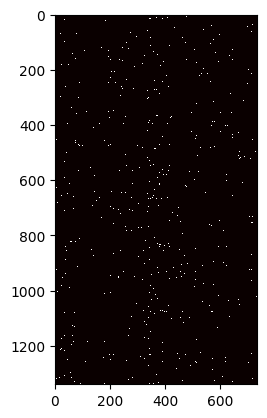

In [4]:
heatmaps([Rt])

Mistake in the problem: the corresponding matrix for items is P (not Q)

In [8]:
import pandas as pd

columns = E0.keys()
df = pd.DataFrame(data=(E0, Et, Em, Ea, Eb), columns=columns)

df.insert(0, 'method', [
    'R (train data)',
    'R (test data)',
    'matrix factorization',
    'BERT replace Q',
    'BERT concat with Q'
])

df

,method,recall,ndcg,rank correlation
0,R (train data),3.847,0.007,1.000
1,R (test data),99,1.000,1.000
2,matrix factorization,27,0.126,-0.003
3,BERT replace Q,2.209,0.004,0.021
4,BERT concat with Q,3.460,0.010,-0.006


set i , j


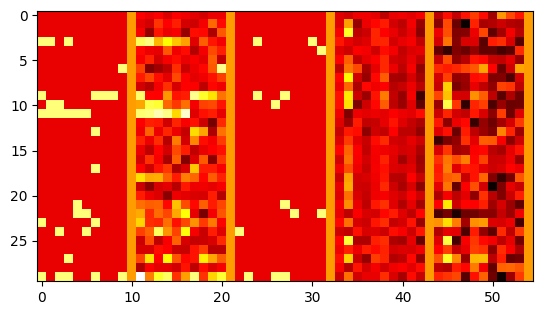

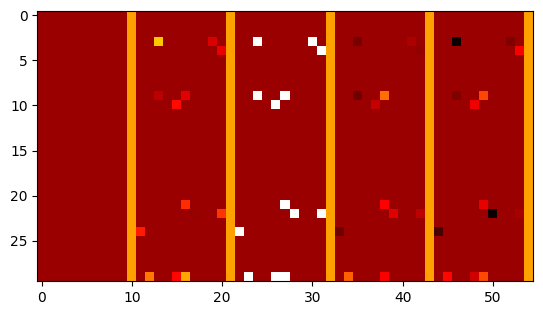

In [9]:
def find_window(w, h):
    n, m = Rt.shape
    a = np.zeros((n-h, m-w))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            a[i,j] = Rt[i:i+h, j:j+w].sum()
    
    return np.unravel_index(a.argmax(), a.shape)

try:
    a = i, j
except:
    i, j = -1, -1

def win(M, width=10, height=30):
    global i, j
    if i < 0 and j < 0:
        i, j = find_window(width, height)
        print("set i , j")

    return M[i:i+height, j:j+width]


RRmRtRaRb = (R, Rm, Rt, Ra, Rb)
RRmRtRaRb = [win(M) for M in RRmRtRaRb]

heatmaps(RRmRtRaRb)
heatmaps([M*win(Rt) for M in RRmRtRaRb])

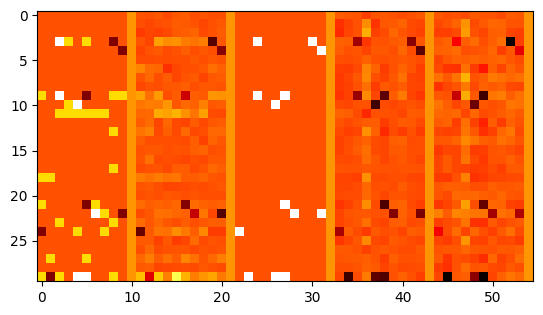

In [8]:
def mark(M, windowed=True):
    # return M
    T = win(Rt) if windowed else Rt
    return M + ((M - 0.5)*(T - 0.5)) * 1.2

heatmaps([mark(win(M)) for M in (R, Rm, Rt, Ra, Rb)])

In [13]:
print("We expect R_train to have almost zero score (since it has zero value for almost every item)")
print(E0)
print()

print("We expect R_test to have almost 1 score (since it has memorized test dataset)")
print(Et)
print()

print("R estimation (with matrix factorization)")
print(Em)
print()

print("Replace Q with BERT's encoding")
print(Ea)
print()

print("Concat BERT encoding")
print(Eb)
print()

We expect R_train to have almost zero score (since it has zero value for almost every item)
{'recall': '3.847', 'ndcg': '0.007', 'rank correlation': '1.000'}

We expect R_test to have almost 1 score (since it has memorized test dataset)
{'recall': '99', 'ndcg': '1.000', 'rank correlation': '1.000'}

R estimation (with matrix factorization)
{'recall': '28', 'ndcg': '0.131', 'rank correlation': '-0.017'}

Replace Q with BERT's encoding
{'recall': '2.006', 'ndcg': '0.005', 'rank correlation': '-0.012'}

Concat BERT encoding
{'recall': '4.160', 'ndcg': '0.011', 'rank correlation': '-0.002'}



In [14]:
Qa, Pa2 = mf(R, qp=(Q, Pb), single_lr=0.001, n_epochs=2, single_epochs=2, sample_s=1, print_step=1, log_step=1) 
Ra2 = Qa @ Pa2.T
evaluate(Ra2)

2it [00:00, 21.41it/s]


best error: 2.19e+04
(1340, 36)
[264 195 357 282  42   3 366 199 300 567 347 560  43 142 344 223  16 541
 280  44]
------
[261  24 188 687 133 255  45 265 131 321]
[264 195 357 282  42   3 366 199 300 567 347 560  43 142 344 223  16 541
 280  44]
------
[261  24 188 687 133 255  45 265 131 321]


{'recall': '6.699', 'ndcg': '0.019', 'rank correlation': '-0.012'}